# Retail Project

### Content

You are provided with historical sales data for 45 stores located in different regions - each store contains a number of departments. The company also runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks.

### Stores

Anonymized information about the 45 stores, indicating the type and size of store

### Features

Contains additional data related to the store, department, and regional activity for the given dates.

Store - the store number
Date - the week
Temperature - average temperature in the region
Fuel_Price - cost of fuel in the region
MarkDown1-5 - anonymized data related to promotional markdowns. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA
CPI - the consumer price index
Unemployment - the unemployment rate
IsHoliday - whether the week is a special holiday week
Sales

Historical sales data, which covers to 2010-02-05 to 2012-11-01. Within this tab you will find the following fields:

Store - the store number
Dept - the department number
Date - the week
Weekly_Sales -  sales for the given department in the given store
IsHoliday - whether the week is a special holiday week
The Task

### Objectives

* Predict the department-wide sales for each store for the following year
* Model the effects of markdowns on holiday weeks
* Provide recommended actions based on the insights drawn, with prioritization placed on largest business impact

# Acquire

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import prepare
import model
from datetime import timedelta, datetime
import os.path

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
sales = pd.read_csv("sales data-set.csv")

In [3]:
store = pd.read_csv("stores data-set.csv")

In [4]:
features = pd.read_csv("features data set.csv")

In [5]:
sales.shape

(421570, 5)

# Prepare

In [6]:
# Need to turn Date into a datetime df

sales.Date = pd.to_datetime(sales.Date)
features.Date = pd.to_datetime(features.Date)

In [7]:
# Are there any null values?

sales.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [8]:
store.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [9]:
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [10]:
features.Date

0      2010-05-02
1      2010-12-02
2      2010-02-19
3      2010-02-26
4      2010-05-03
          ...    
8185   2013-06-28
8186   2013-05-07
8187   2013-12-07
8188   2013-07-19
8189   2013-07-26
Name: Date, Length: 8190, dtype: datetime64[ns]

It seens that the only df with null values is `features`. The features missing are mostly the markdowns (which we expected, as they began recording them starting in 2011. We also seem to be missing about 500 datapoints for `CPI` and `Unemployment`. I am still not sure how I want to use these features specifically, but I am likely going to replace them with zero, or another close value.

In [11]:
# Lets merge the df

df = sales.merge(store, how="left", on="Store")
df = df.merge(features, how="left", on=["Date", "Store"])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday_x     421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
IsHoliday_y     421570 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(10), int64(3), object(1)
memory usage: 52.3+ MB


In [13]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-05-02,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-12-02,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-05-03,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [14]:
df = df.set_index("Date")

df = df.sort_index()

In [15]:
df.index.min()

Timestamp('2010-01-10 00:00:00')

In [16]:
# How do we handle the missing values?

df.loc["2011-11-01":"2011-11-12"]

,Store,Dept,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
Date,,,,,,,,,,,,,,,,
2011-11-02,29,35,1917.03,True,B,93638,28.89,3.255,NaN,NaN,NaN,NaN,NaN,133.260871,10.256,True
2011-11-02,30,6,7.44,True,C,42988,34.61,3.022,NaN,NaN,NaN,NaN,NaN,212.592862,8.028,True
2011-11-02,23,34,20330.29,True,B,114533,21.52,3.255,NaN,NaN,NaN,NaN,NaN,133.260871,5.114,True
2011-11-02,9,6,2410.44,True,B,125833,34.13,3.022,NaN,NaN,NaN,NaN,NaN,216.496729,6.416,True
2011-11-02,36,87,269.96,True,A,39910,41.16,3.009,NaN,NaN,NaN,NaN,NaN,211.698509,8.395,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-11,37,81,10617.52,False,C,39910,63.50,3.297,8.62,56.53,117.92,NaN,796.28,216.721737,7.716,False
2011-11-11,33,14,900.94,False,A,39690,58.75,3.677,105.63,126.28,5.06,NaN,27754.23,129.816710,8.010,False
2011-11-11,32,82,20501.28,False,A,203007,38.10,3.505,21104.84,7842.47,47.56,3908.03,4246.86,195.637694,8.513,False


Given that there is no data before 2012 that can help us actually measure `MarkDown`, I will impude the missing values with zero. In the future, if we want to actually look at the impact of discounts and markdowns, the impact of the actual data will be far more useful, rather than diluting the information by using the mean.

If time allows, I propose the following strategies to impude the markdown:

1. Group the markdowns by store, and see if there are any easy patterns that can help us accurately impude those values. I suspect that there might be some cyclical component to it, and this would be easier to see on a store by store basis. 
1. If we see that there is a strong correlation with other features, such as `CPI`, we can use linear regression models to predict the missing `Markdown` values.

In [17]:
# Impude markdown with zero

df = df.fillna(0)

In [18]:
df["Weekly_Sales"].dtype == bool

False

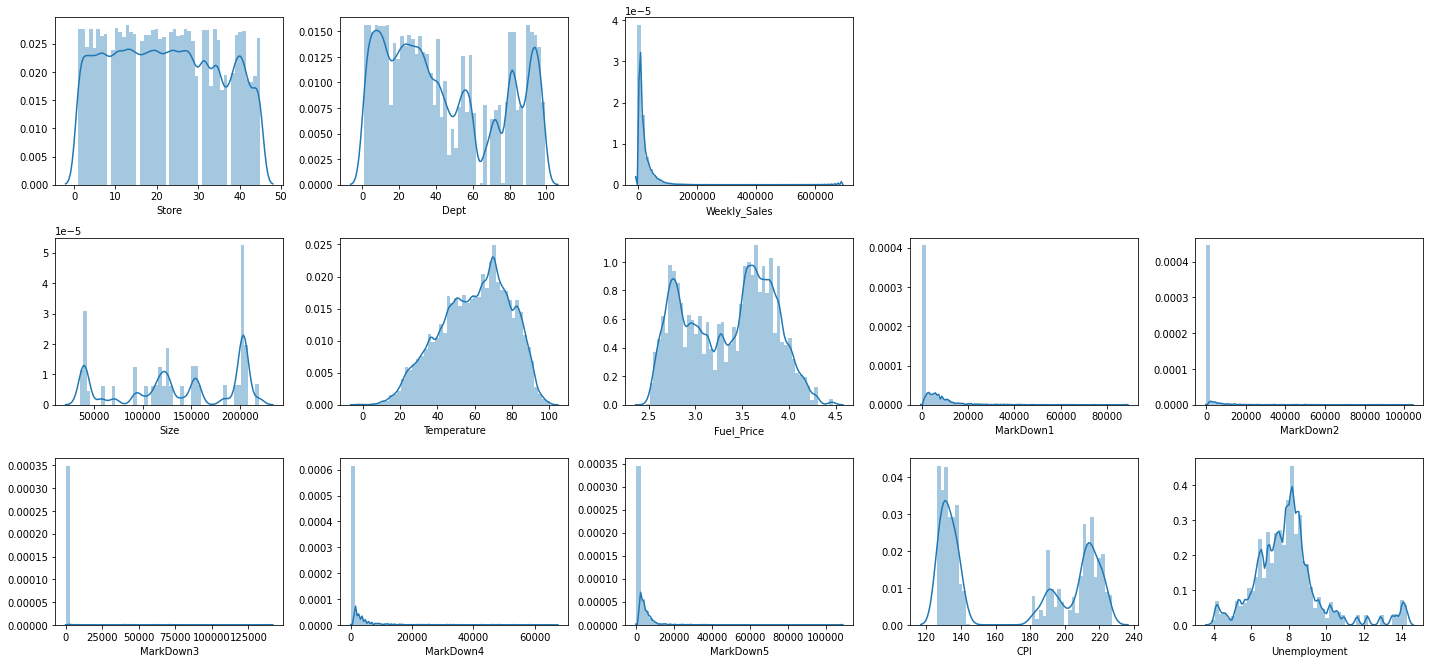

In [19]:
# Are there any outliers?
f = plt.figure(figsize=(20,15))
for count, col in enumerate(df):
    if df[col].dtype != object and df[col].dtype != bool:
        f.add_subplot(5,5, count+1)
        sns.distplot(df[col])
plt.tight_layout()
plt.show()

Looking at the distribution plots above, there are several features that don't have normal distributions. The most important one being the `Weekly_Sales`, which is very much right skewed. 

The `MarkDowns` also have a significant amount of outliers, but I am less worried about these, as they can help us understand the impact of discounts on sales. 

The rest of the features have a more normally distributed data. I will do some exploration on the `Weekly_Sales` to understand if the outliers are perhaps specific to ceirtain holidays or ceirtain stores.

In [20]:
df.Weekly_Sales.mean(), df.Weekly_Sales.std()  

(15981.25812346753, 22711.183519163056)

In [21]:
(df.Weekly_Sales > (df.Weekly_Sales.mean() + (df.Weekly_Sales.std()) * 2)).mean()

0.049607419882818984

We can see that a very small number of the data (~5%) is further than 3 standard deviations of the mean. We will leave these anomalies in the data, and we will try to better understand what insights they can give us.

### Fixing the time lag

In [ ]:
# df[["Store", "Dept", "Size"]] = df[["Store", "Dept", "Size"]].astype("object")

In [54]:
df.index.unique().shape

(154,)

In [53]:
(df.index.max() - df.index.min()) / 7

Timedelta('153 days 00:00:00')

In [ ]:
# Main loop that we can use to ensure that the data comes with no missing timelags.
# dept_numbers = df[df.Store == 4].Dept.unique()

# store_numbers = df.Store.unique()

# new_df = pd.DataFrame()

# for store in store_numbers:

#     for department in dept_numbers:
#         df_debug = df[(df.Store == store) & (df.Dept == department)]
#         df_debug = df_debug.groupby(df_debug.index).sum().resample("W").mean().ffill()
#         new_df = pd.concat([df_debug, new_df])

# new_df = new_df.sort_index()

In [76]:
# To reduce load times, I will write the data as a new, clean CSV. 

if os.path.exists("retail_clean_data.csv") == False:
    df = prepare.wrangle_sales()
    df.to_csv("retail_clean_data.csv")
    

# Explore

Now that the data is compiled into one dataframe, and it is in a tidy manner, with no missing values, we can move on to explore the data.

### Questions:

* Our first objective is to predict sales for each store for the next year. As such, we will focus on answering questions like:
    1. Is there a seasonality for `Weekly_Sales`
    1. Is there a trend for `Weekly_Sales`
    1. Is there a significant difference in sales between the different stores.
    1. How does trend and seasonality vary by department / type of store

* Our second question asks us to model the effects of `Markdowns` on holidays:
    1. Is there a relationship between `Markdowns` and holidays
    1. Is there a seasonality to `Markdowns`
    
* Our last objective is to make recommendations for the greater business:
    1. Are there any stores that are unprofitable?
    1. Are there time period where stores need to increase staffing due to seasonality?
    1. Does `fule_price` and `unemployment` have an impact on `Weekly_Sales`?
    
**There are many more questions that we could ask from this data - but these will be the ones that we will focus on at the moment. If there is more time to work on this analysis, we can look to extend our exploration phase.**

In [229]:
df = pd.read_csv("retail_clean_data.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")

In [230]:
# Split our data

train = df[:"2011-12-31"]
validate = df["2012-01-01":"2012-06-01"]
test = df["2012-06-02":]

(array([733773., 733893., 734016., 734138., 734258., 734381., 734503.,
        734624., 734747., 734869.]),
 <a list of 10 Text major ticklabel objects>)

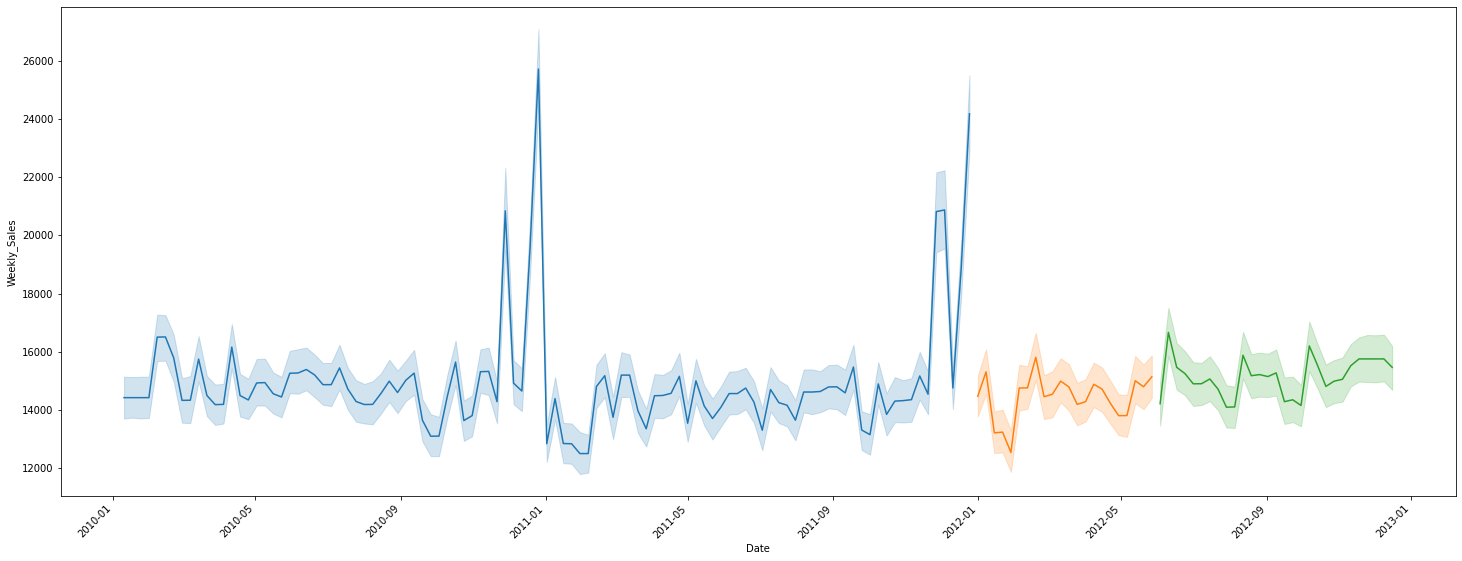

In [231]:
plt.figure(figsize=(25,9))
prepare.plot_splits(train, validate, test, "Weekly_Sales")
plt.xticks(rotation=45, ha="right")

### Is there a seasonality for Weekly_Sales?

In [24]:
import explore

In [318]:
# explore.seasonal_decomposition(y, "Weekly_Sales", "W")

Interestingly, it does seem that there is some seasonality in the data. Overall, it seems that sales pick up towards the beginning of November, all the way through Dec, and then sales drop towards early Jan.

This clearly reflects the holiday season, where people are likely buying presents for each other begining on Black Friday, through the Dec 25th. 

There actually seems to be a slighly negative trend in sales. This will need to be analysise further, as it can have a great impact on the business recommendations we make.

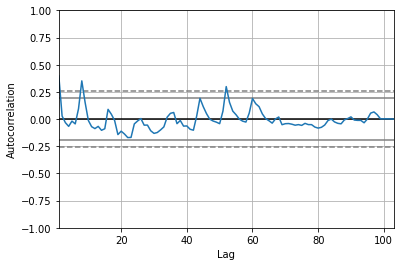

In [321]:
pd.plotting.autocorrelation_plot(train[(train.Store==4) & (train.Dept==1)].Weekly_Sales)

it doesn't actually seem like there is a significant correlation between sales and seasonality, as the lines in the autocorrelation graph are all within the error boudnaries. That is a bit suprising, and we might have to do some further analysis, as it might be that the outliers are actully skewing the data.

### Is there a significant difference in sales between the different stores?

In [27]:
# How many stores are there? 

print(f'There are {train.Store.unique().shape[0]} unique stores in the database')

There are 45 unique stores in the database


In [28]:
train.Store = train.Store.astype("object")

Text(0.5, 1.0, 'Yearly Sales Per Store')

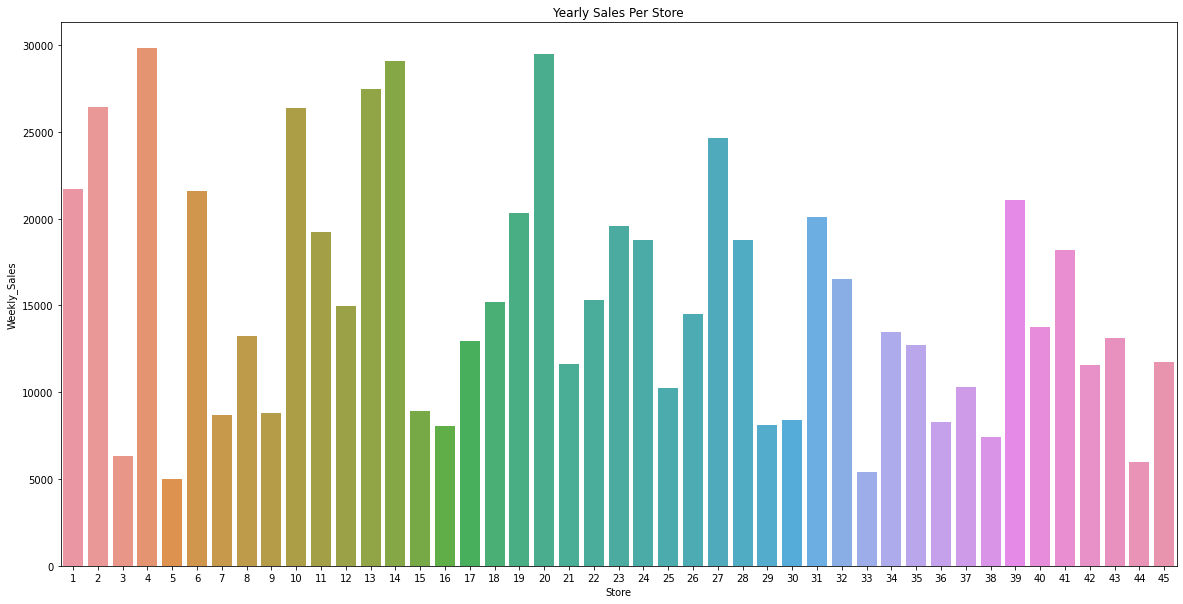

In [29]:
sales = train["2011"].groupby("Store")[["Weekly_Sales"]].resample("Y").mean().reset_index().sort_values(by="Weekly_Sales", ascending=False)

plt.figure(figsize=(20,10))
sns.barplot(data=sales, x="Store", y="Weekly_Sales")
plt.title("Yearly Sales Per Store")

In [30]:
# What is the range of sales?

print(f'The mean sales is: ${train.Weekly_Sales.mean():,.0f}, the STD is ${train.Weekly_Sales.std():,.0f}')

The mean sales is: $16,105, the STD is $22,961


In [31]:
print(f'''

Store # 4 seems to have the highest sales, with average yearly sales of ${sales[sales.Store == 4].Weekly_Sales.values[0]:,.0f}

The lowest selling store is #33, with average yearly sales of ${sales[sales.Store == 5].Weekly_Sales.values[0]:,.0f}

''')



Store # 4 seems to have the highest sales, with average yearly sales of $29,831

The lowest selling store is #33, with average yearly sales of $4,982




### How does trend and seasonality vary by department / type of store?

In [32]:
train.Dept = train.Dept.astype("object")

In [33]:
print(f'There are {train.Dept.unique().shape[0]} unique departments in this database')

There are 81 unique departments in this database


Text(0.5, 1.0, 'Do all stores have the same departments?')

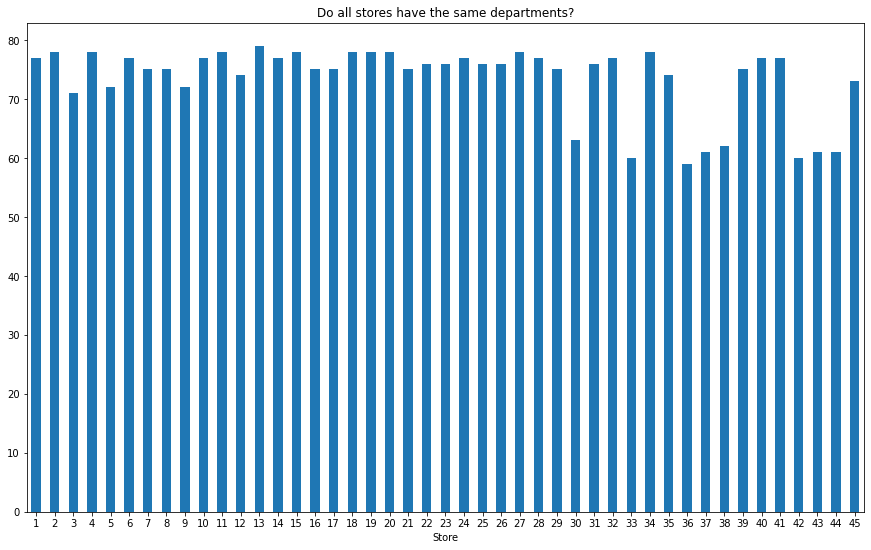

In [34]:
# Do all stores have all departments?

train.groupby(["Store"]).Dept.nunique().plot.bar(figsize=(15, 9))
plt.xticks(rotation= 0)
plt.title("Do all stores have the same departments?")

It seems that the majority of stores have a similar amount of departments, with some of departments having around 75, and others as low as 55. 

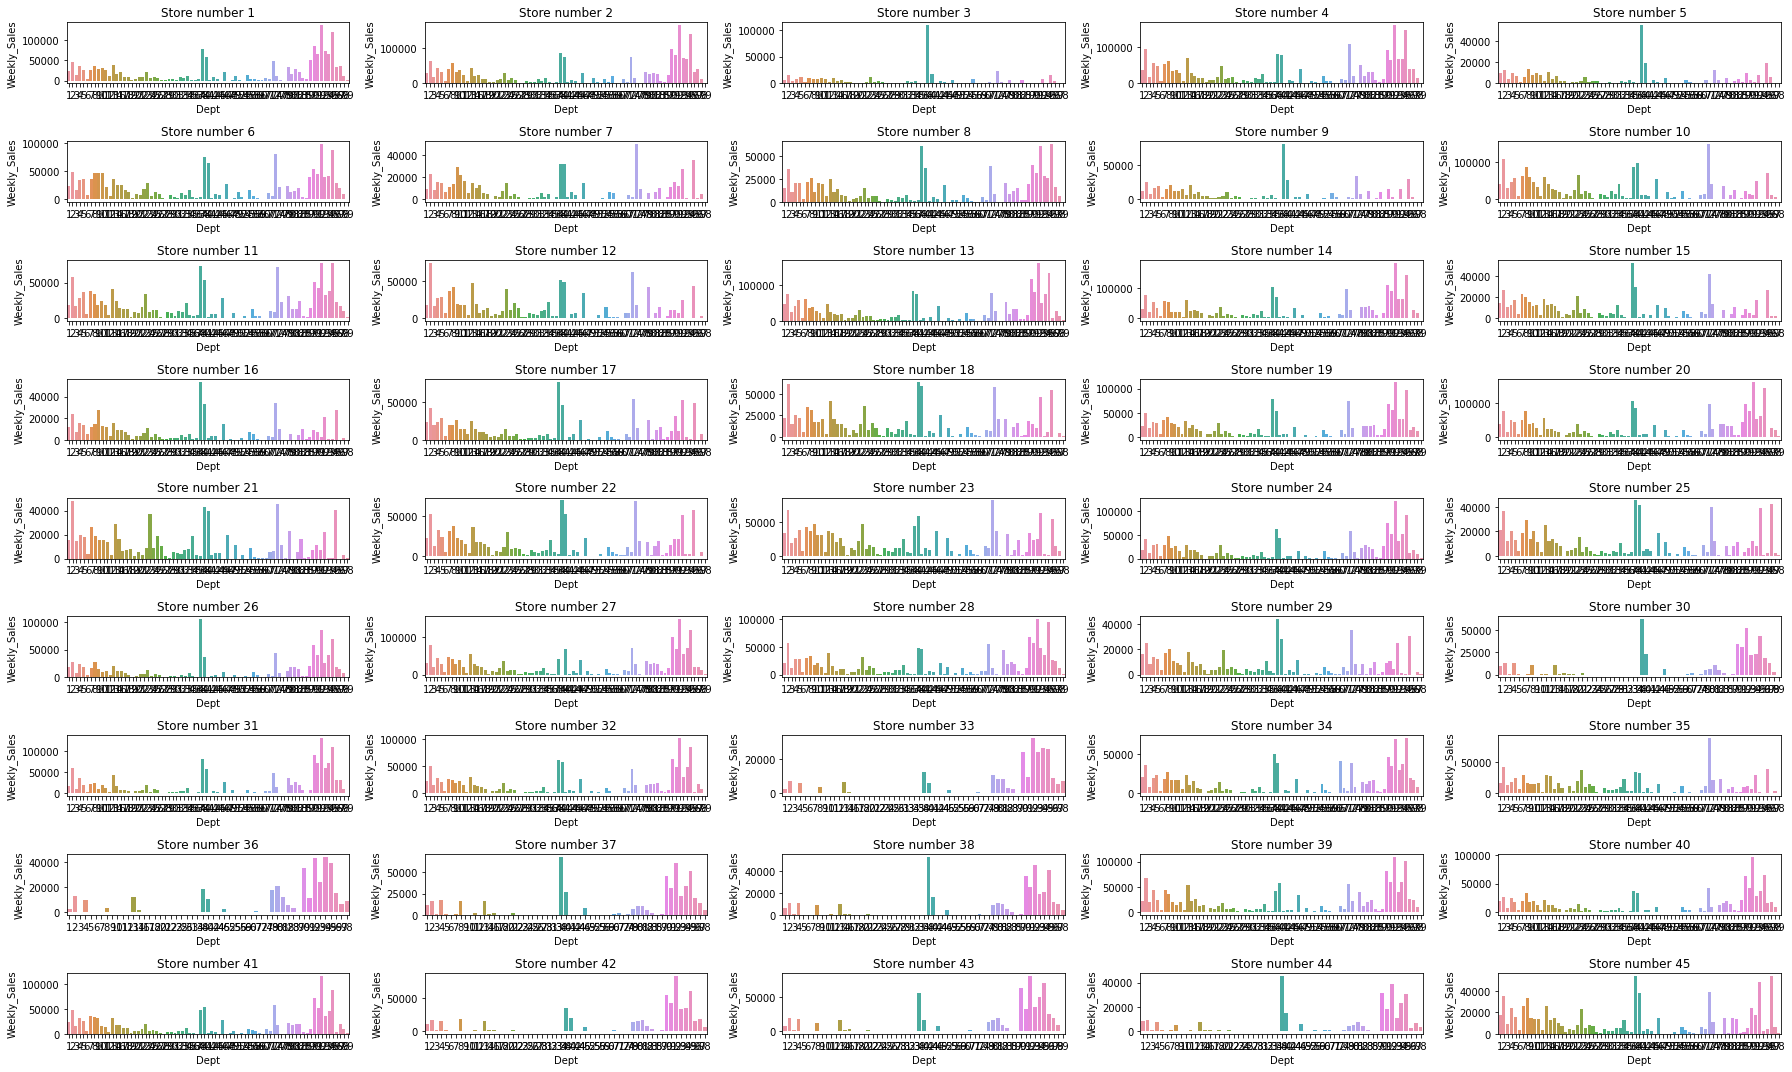

In [35]:
train_11 = train["2011"]
f = plt.figure(figsize=(25, 15))
# plt.suptitle("Avg Sales by Department")
for i in range(1,46):
    store = train_11[train_11.Store == i].groupby(["Store", "Dept"])[["Weekly_Sales"]].mean().reset_index()
    f.add_subplot(9, 5, i)
    sns.barplot(data=store, x="Dept", y="Weekly_Sales")
    plt.title(f'Store number {i}')
plt.tight_layout()

Some key takeaways:

* There seems to be a general trend, with departments 38 - 40 being highely profitable. 
* A similar trend can be seen with departments 90 - 97. 

* Stores where most departments seem to be doing poorly:
    * Store 3
    * Store 5
    * Store 9
    * Store 42 - 44
    
* Stores that are, on average, performing well across most departments (not just on some):
    * Store 2
    * Store 4
    * Store 6 
    * Store 7
    * Store 16
    * Store 21 - 25

Text(0.5, 1.0, 'Sales by deparment in Store 1')

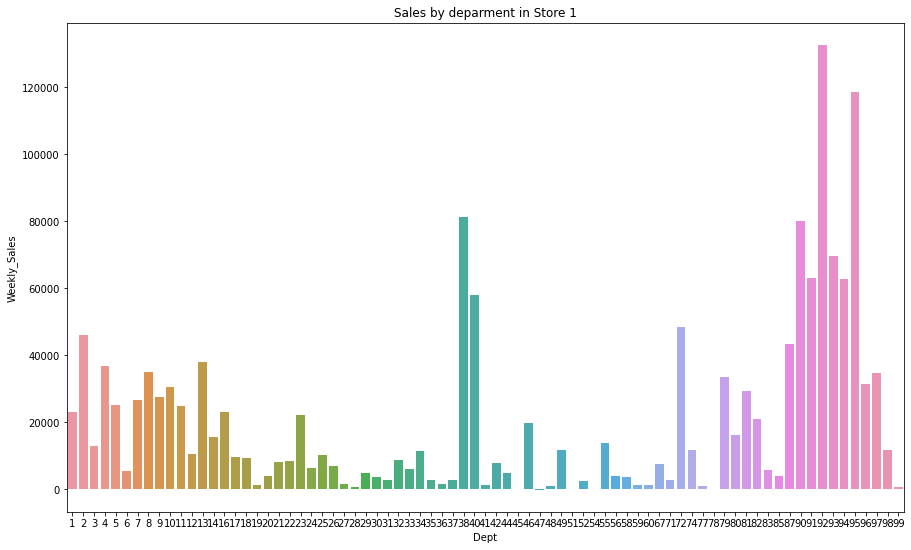

In [36]:
store = train[train.Store == 1].groupby(["Store", "Dept"])[["Weekly_Sales"]].mean().reset_index()
plt.figure(figsize=(15, 9))
sns.barplot(data=store, x="Dept", y="Weekly_Sales")
plt.title("Sales by deparment in Store 1")

There definitvely seems to be a correlation between sales and department, with some departments bringing far more revenue than others.

Text(0.5, 1.0, 'Mean Income Per Department in 2011')

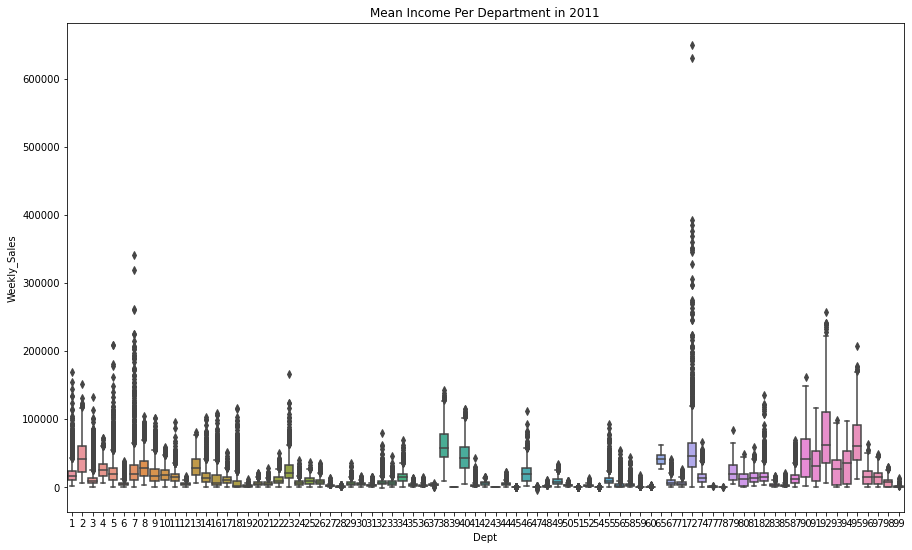

In [37]:
# What is the average income per department?
plt.figure(figsize=(15, 9))
sns.boxplot(data=train_11, x="Dept", y="Weekly_Sales")
plt.title("Mean Income Per Department in 2011")

It definitvely seems that across all stores, some departments are more profitable than others. Department # 73 for example has an extremly high high income, but this is also largely driven by some very high outliers. That being said, there are some departments that seem, on average, to actually lose money. These could be some key features that we could look to recommend to improve to the business.

### Are sales impacted by unemployment rates?

Text(0.5, 1.0, 'Are sales higher in places with lower unemployment?')

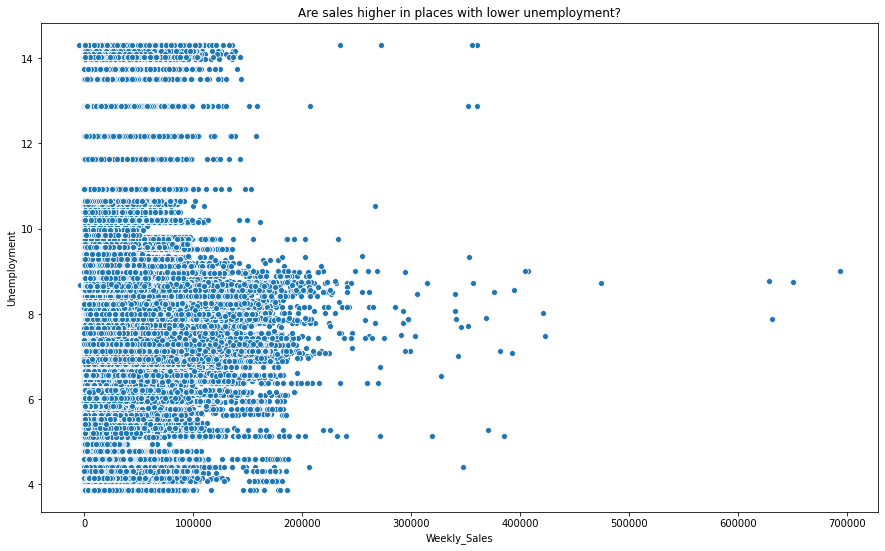

In [38]:
plt.figure(figsize=(15, 9))
sns.scatterplot(data=df, x="Weekly_Sales", y="Unemployment")
plt.title("Are sales higher in places with lower unemployment?")

It doesn't seem that there is a particular relationship between retail sales and unemployment rates. There definitively seems like there are some outliers. A good next step might be to look at the markdown information to see if these are related. 

# Modeling

* We have finished our first phase of exploration, and we are ready to look at creating predictions for the stores over the next full year. 

* We will be using Facebook Prophet's model to create the predictions, and we will use the moving average as a baseline.

### We need to model sales by store - eventually we can do it by department. So this means that we will need to split the data.  For practice, we will run the models on one store, to ensure everything is working fine, and then we will deploy a loop to run through al lthe stores. 

In [109]:
df = pd.read_csv("retail_clean_data.csv")

In [110]:
df.Date = pd.to_datetime(df.Date)

In [111]:
df = df.set_index("Date")

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 484140 entries, 2010-01-10 to 2012-12-16
Data columns (total 15 columns):
Store           484140 non-null float64
Dept            484140 non-null float64
Weekly_Sales    484140 non-null float64
IsHoliday_x     484140 non-null float64
Size            484140 non-null float64
Temperature     484140 non-null float64
Fuel_Price      484140 non-null float64
MarkDown1       484140 non-null float64
MarkDown2       484140 non-null float64
MarkDown3       484140 non-null float64
MarkDown4       484140 non-null float64
MarkDown5       484140 non-null float64
CPI             484140 non-null float64
Unemployment    484140 non-null float64
IsHoliday_y     484140 non-null float64
dtypes: float64(15)
memory usage: 59.1 MB


In [113]:
train = df[:"2011-12-31"]
validate = df["2012-01":"2012-06"]
test = df["2012-06":]

In [114]:
train_model = train[(train.Store== 4) & (train.Dept == 1)]

In [115]:
validate_model = validate[(validate.Store == 4) & (validate.Dept == 1)]

In [116]:
target_variable = "Weekly_Sales"

In [117]:
predictions = model.run_all_models(train_model, validate_model, target_variable, [4, 8, 16])

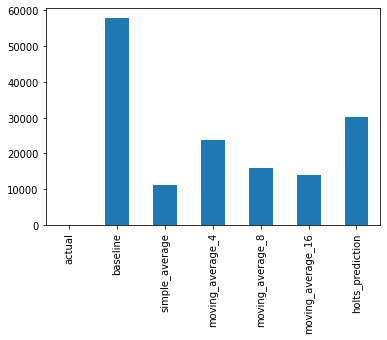

In [118]:
# Evaluate

model.plot_rmse(predictions)

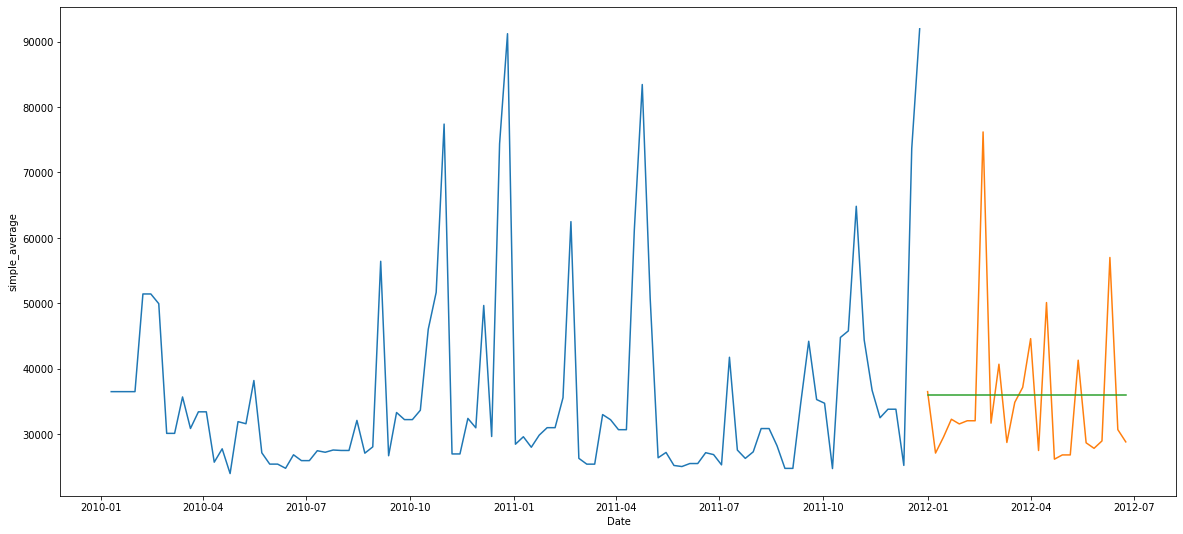

In [121]:
model.plot_prediction("simple_average", "Weekly_Sales", train_model, validate_model, predictions)

In [209]:
rmse = (round(sqrt(mean_squared_error(predictions.actual, predictions["simple_average"])), 0))

In [211]:
print(f'''

As we can see - it seems that the simple average performs better than the 
baseline. The mean rmse for the simple_average is ${rmse:,.0f}.

We will use this as a comparison for when we forcast using facebook's prophet.
      
''')



As we can see - it seems that the simple average performs better than the 
baseline. The mean rmse for the simple_average is $11,140.

We will use this as a comparison for when we forcast using facebook's prophet.
      



In [129]:
df = pd.read_csv("retail_clean_data.csv")

In [ ]:
# df[["Store", "Dept", "Size"]] = df[["Store", "Dept", "Size"]].astype("object")

In [130]:
df.Date = pd.to_datetime(df.Date)

df = df.set_index("Date")

In [132]:
df = df[(df.Store == 4) & (df.Dept == 1)]

In [133]:
df = model.prep_fb(df, 'Weekly_Sales')

In [134]:
train = df[:"2011-12-31"]
validate = df["2012-01-01":"2012-06-01"]
test = df["2012-06-02":]

In [221]:
# FB Prophet Model

m, df_cv = model.run_prophet(train, validate, test, "Weekly_Sales", (train.y.max() * 1),(train.y.min() * 1), "300 day", "160 days", "160 days"  )

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2011-02-08 00:00:00 and 2011-07-18 00:00:00


In [222]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,13 days,2.199119e+08,14829.427589,11015.569721,0.265287,0.307533,0.75
1,19 days,2.397646e+08,15484.333679,13159.614589,0.347690,0.335640,0.75
2,20 days,2.250539e+08,15001.795872,12018.293928,0.298410,0.311112,0.75
3,26 days,6.314138e+07,7946.155278,7651.031725,0.285766,0.311112,1.00
4,27 days,5.256042e+07,7249.856706,6760.486090,0.248732,0.237080,1.00


In [332]:
i =df_cv.set_index("ds").sort_index()

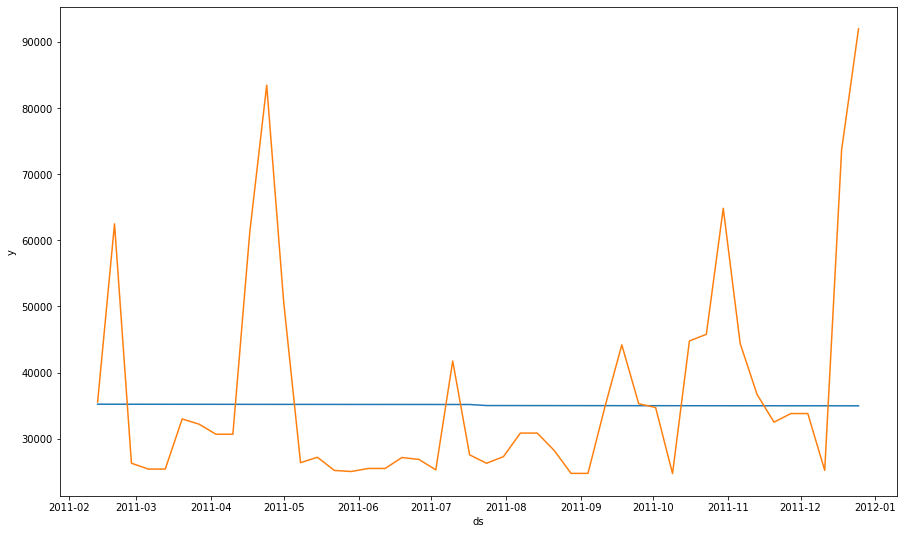

In [340]:
plt.figure(figsize=(15,9))
sns.lineplot(data=i, x=i.index, y="yhat")
sns.lineplot(data=i, x=i.index, y="y")

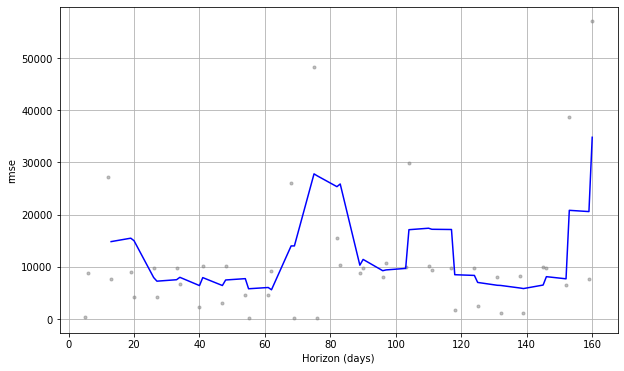

In [223]:
fig = plot_cross_validation_metric(df_cv, metric = 'rmse', rolling_window = .1)

In [224]:
print(f"The model is off, on average, by ${df_p.rmse.mean():,.0f}. The average mape is {df_p.mape.mean():.0}")

The model is off, on average, by $12,323. The average mape is 0.3


------

## Objective I 

Make predictions, by store, for the full next year.

Because of the large data set, and the fact the Facebook Prophet model didn't perform significantly better than our baseline, we will be using the simple_average to predict next year's sales. I would have prefer to use FB Prophet, but the data set is too large, and the fact that there are so many individual stores, means that the process would be too computationally expensive. If given access to more computational power, I would suggest using FB to predict future sales.

In [493]:
# Create a new df with a new index for the time-frame we want to forcast.
next_year = pd.date_range("2013-01", "2013-12", freq='W')

In [494]:
# Creates list of unique values for stores and departments
unique_stores = df.Store.unique()

# unique_dept = df[df.Store == ].Dept.unique()

In [495]:
# Read the data
df = pd.read_csv("retail_clean_data.csv")

df.Date = pd.to_datetime(df.Date)

df = df.set_index("Date")

In [496]:
forecast = pd.DataFrame()
predictions = pd.DataFrame({"ds": next_year})
for store in unique_stores:
    unique_dept = df[df.Store == store].Dept.unique()
    for department in unique_dept:
        predictions["store"] =  store
        predictions["dept"] = department
        predictions["predictions"] = df[(df.Store == store) & (df.Dept == department)].Weekly_Sales.mean()
        forecast = pd.concat([forecast, predictions])



Text(0.5, 1.0, 'Expected sales of 2013 by store')

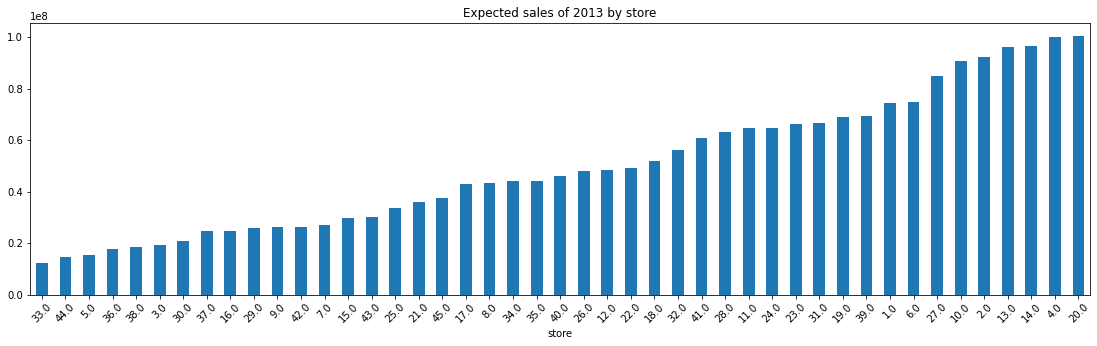

In [497]:
forecast.groupby("store").predictions.sum().sort_values().plot.bar(figsize=(19, 5))
plt.xticks(rotation=45)
plt.title("Expected sales of 2013 by store")

We can see from the forecast above that there will be a wide distribution of sales by stores.

In [490]:
# Top 5 performing stores for 2013, according the predictions

forecast.groupby("store").predictions.mean().nlargest(5).round(0)

store
20.0    27148.0
14.0    26826.0
4.0     26747.0
13.0    25957.0
10.0    24834.0
Name: predictions, dtype: float64

In [491]:
# Bottom 5 performing stores for 2013, according to the predictions

forecast.groupby("store").predictions.mean().nsmallest(5).round(0)

store
33.0    4125.0
5.0     4433.0
44.0    4918.0
3.0     5589.0
36.0    5917.0
Name: predictions, dtype: float64

------------

# Next Phase: 

Make business recommendations - Key Ideas at the moment:

1. Look at the relationship between sales and environment variables (temperature, price_gas, unemployment rate)
1. Compare sales between size by looking at the number of departments (some stores have more / less departments, which could be a reason why they have lower sales). 
1. Look at which departments are most profitable (and see if it is possible to recommend other stores to get these departments)
1. Dig deeper into the markdown information to see if we could improve the markdown startegy.